## General


Cost Map 2d/3d

In [1]:
import numpy as np
x_dim = 850
y_dim = x_dim
center_x, center_y = x_dim / 2, y_dim / 2
inner_radius, outer_radius = 250, 400
ref_x, ref_y = center_x, center_y + (inner_radius + outer_radius) / 2
opponent_x, opponent_y = ref_x, ref_y

def proximity_cost(x1, y1, threshold=50, weight=1.0):
    dx = x1 - opponent_x
    dy = y1 - opponent_y
    dist = np.sqrt(dx ** 2 + dy ** 2)
    cost = np.zeros_like(dist)
    within = dist < threshold

    # cost[within] = weight * np.exp(-(2 * 1 / threshold * dist[within]))
    cost[within] = weight * (1 - dist[within]/threshold)

    return cost

In [2]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

# Constants - adjust these to modify the visualization
resolution = 200
x_dim = 850
y_dim = x_dim

# Cost function weights
bounds_weight = 0.005
progress_weight = 0.08
proximity_weight = 1.0
bounds_spread = 205
proximity_threshold = 50

# Track geometry
center_x, center_y = x_dim / 2, y_dim / 2
inner_radius, outer_radius = 250, 400

# Vehicle positions
ref_x, ref_y = center_x, center_y + (inner_radius + outer_radius) / 2
opponent_x, opponent_y = ref_x, ref_y
ego_x, ego_y = center_x, center_y - (inner_radius + outer_radius) / 2

# Create coordinate grid
x = np.linspace(0, x_dim, resolution)
y = np.linspace(0, y_dim, resolution)
X, Y = np.meshgrid(x, y)

def out_of_bounds_cost(x, y, weight=1, spread=100):
    dx = x - center_x
    dy = y - center_y
    distance_to_center = np.hypot(dx, dy)
    
    # Initialize cost array with zeros
    cost = np.zeros_like(distance_to_center)
    
    # Inside inner radius
    inside_mask = distance_to_center < inner_radius
    cost = np.where(inside_mask, weight * (inner_radius - distance_to_center), cost)
    
    # Outside outer radius
    outside_mask = distance_to_center > outer_radius
    cost = np.where(outside_mask, weight * (distance_to_center - outer_radius), cost)
    
    # Between inner and outer radius, cost remains 0
    return cost

def relative_progress_cost(x1, y1, weight=1):
    def angle(x, y):
        return (np.arctan2(y - center_y, x - center_x) + 2 * np.pi) % (2 * np.pi)
    angle1 = angle(x1, y1)
    angle2 = angle(ref_x, ref_y)
    delta = angle1 - angle2
    delta = np.where(delta < -np.pi, delta + 2 * np.pi, delta)
    delta = np.where(delta > np.pi, delta - 2 * np.pi, delta)
    return weight * delta



def generate_circle(cx, cy, radius, resolution=200):
    theta = np.linspace(0, 2 * np.pi, resolution)
    x_circle = cx + radius * np.cos(theta)
    y_circle = cy + radius * np.sin(theta)
    return x_circle, y_circle

# Calculate combined cost surface
Z1 = out_of_bounds_cost(X, Y, bounds_weight, spread=bounds_spread)
Z2 = relative_progress_cost(X, Y, progress_weight)
Z3 = proximity_cost(X, Y, threshold=proximity_threshold, weight=proximity_weight)
Z = Z1 + Z2 + Z3

# Get z-values for vehicle positions
ix = np.abs(x - opponent_x).argmin()
iy = np.abs(y - opponent_y).argmin()
opponent_z = Z[iy, ix]

ix = np.abs(x - ego_x).argmin()
iy = np.abs(y - ego_y).argmin()
ego_z = Z[iy, ix-10]

# Generate track boundary circles
inner_x, inner_y = generate_circle(center_x, center_y, inner_radius)
outer_x, outer_y = generate_circle(center_x, center_y, outer_radius)

# Create subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('2D Cost Surface', '3D Cost Surface'),
    specs=[[{"type": "xy"}, {"type": "scene"}]],
    horizontal_spacing=0.1
)
fig.update_annotations(font_size=24)

# Add 2D heatmap plot (left subplot)
fig.add_trace(
    go.Heatmap(
        z=Z, x=x, y=y,
        colorscale='Viridis',
        showlegend=False,
        colorbar=dict(
                x=0.45, 
                len=0.8, 
                title=dict(
                    text="Cost Value",
                    side="right",
                    font=dict(size=18)
                ))),
    row=1, col=1
)

# Add track boundaries to 2D plot
fig.add_trace(
    go.Scatter(
        x=inner_x, y=inner_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=outer_x, y=outer_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)

# Add vehicle markers to 2D plot
fig.add_trace(
    go.Scatter(
        x=[opponent_x], y=[opponent_y],
        mode='markers+text',
        marker=dict(size=10, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=[ego_x], y=[ego_y],
        mode='markers+text',
        marker=dict(size=10, color='green'),
        text=["<b>Ego</b>"],
        textposition='middle left',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)

# Add 3D surface plot (right subplot)
fig.add_trace(
    go.Surface(
        z=Z, x=X, y=Y,
        colorscale='Viridis',
        opacity=0.95,
        showlegend=False,
        showscale=False
    ),
    row=1, col=2
)

# Add track boundaries to 3D plot
inner_z = np.full_like(inner_x, Z.min())
outer_z = np.full_like(outer_x, Z.min())
fig.add_trace(
    go.Scatter3d(
        x=inner_x, y=inner_y, z=inner_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=outer_x, y=outer_y, z=outer_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)

# Add vehicle markers to 3D plot
fig.add_trace(
    go.Scatter3d(
        x=[opponent_x], y=[opponent_y], z=[opponent_z],
        mode='markers+text',
        marker=dict(size=6, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=[ego_x], y=[ego_y], z=[ego_z],
        mode='markers+text',
        marker=dict(size=6, color='green'),
        text=["<b>Ego</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    width=1400,
    height=700,
    showlegend=False,
)

# Update 2D subplot axes
fig.update_xaxes(title_text="X", row=1, col=1)
fig.update_yaxes(title_text="Y", row=1, col=1)

# Update 3D scene
fig.update_scenes(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Cost",
    aspectmode='manual',
    aspectratio=dict(x=1, y=1, z=0.3),
    row=1, col=2
)

# Show the plot
fig.show()

In [3]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

# Constants - adjust these to modify the visualization
resolution = 200
x_dim = 850
y_dim = x_dim

# Cost function weights
bounds_weight = 0.6
progress_weight = 0.2
proximity_weight = 1.0
bounds_spread = 180
proximity_threshold = 50

# Track geometry
center_x, center_y = x_dim / 2, y_dim / 2
inner_radius, outer_radius = 250, 400

# Vehicle positions
ref_x, ref_y = center_x, center_y + (inner_radius + outer_radius) / 2
opponent_x, opponent_y = ref_x, ref_y
ego_x, ego_y = center_x, center_y - (inner_radius + outer_radius) / 2

# Create coordinate grid
x = np.linspace(0, x_dim, resolution)
y = np.linspace(0, y_dim, resolution)
X, Y = np.meshgrid(x, y)

def out_of_bounds_cost(x, y, weight=1, spread=100):
    dx = x - center_x
    dy = y - center_y
    distance_to_center = np.hypot(dx, dy)
    radius = (outer_radius + inner_radius) / 2
    distance_to_perimeter = abs(distance_to_center - radius)
    cost = weight * (1 - np.exp(-(2 / spread * distance_to_perimeter) ** 2))
    return cost

def relative_progress_cost(x1, y1, weight=1):
    def angle(x, y):
        return (np.arctan2(y - center_y, x - center_x) + 2 * np.pi) % (2 * np.pi)
    angle1 = angle(x1, y1)
    angle2 = angle(ref_x, ref_y)
    delta = angle1 - angle2
    delta = np.where(delta < -np.pi, delta + 2 * np.pi, delta)
    delta = np.where(delta > np.pi, delta - 2 * np.pi, delta)
    return weight * delta

def proximity_cost(x1, y1, threshold=50, weight=1.0):
    dx = x1 - opponent_x
    dy = y1 - opponent_y
    dist = np.sqrt(dx ** 2 + dy ** 2)
    cost = np.zeros_like(dist)
    within = dist < threshold
    cost[within] = weight * np.exp(-(2 * 1 / threshold * dist[within]))
    return cost

def generate_circle(cx, cy, radius, resolution=200):
    theta = np.linspace(0, 2 * np.pi, resolution)
    x_circle = cx + radius * np.cos(theta)
    y_circle = cy + radius * np.sin(theta)
    return x_circle, y_circle

# Calculate combined cost surface
Z1 = out_of_bounds_cost(X, Y, bounds_weight, spread=bounds_spread)
Z2 = relative_progress_cost(X, Y, progress_weight)
Z3 = proximity_cost(X, Y, threshold=proximity_threshold, weight=proximity_weight)
Z = Z1 + Z2 + Z3

# Get z-values for vehicle positions
ix = np.abs(x - opponent_x).argmin()
iy = np.abs(y - opponent_y).argmin()
opponent_z = Z[iy, ix]

ix = np.abs(x - ego_x).argmin()
iy = np.abs(y - ego_y).argmin()
ego_z = Z[iy, ix-10]

# Generate track boundary circles
inner_x, inner_y = generate_circle(center_x, center_y, inner_radius)
outer_x, outer_y = generate_circle(center_x, center_y, outer_radius)

# Create subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('2D Cost Surface', '3D Cost Surface'),
    specs=[[{"type": "xy"}, {"type": "scene"}]],
    horizontal_spacing=0.1
)
fig.update_annotations(font_size=24)

# Add 2D heatmap plot (left subplot)
fig.add_trace(
    go.Heatmap(
        z=Z, x=x, y=y,
        colorscale='Viridis',
        showlegend=False,
        colorbar=dict(x=0.45, len=0.8, 
                      title=dict(text="Cost Value", side="right", font=dict(size=18)))
    ),
    row=1, col=1
)

# Add track boundaries to 2D plot
fig.add_trace(
    go.Scatter(
        x=inner_x, y=inner_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=outer_x, y=outer_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)

# Add vehicle markers to 2D plot
fig.add_trace(
    go.Scatter(
        x=[opponent_x], y=[opponent_y],
        mode='markers+text',
        marker=dict(size=10, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=[ego_x], y=[ego_y],
        mode='markers+text',
        marker=dict(size=10, color='green'),
        text=["<b>Ego</b>"],
        textposition='middle left',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)

# Add 3D surface plot (right subplot)
fig.add_trace(
    go.Surface(
        z=Z, x=X, y=Y,
        colorscale='Viridis',
        opacity=0.95,
        showlegend=False,
        showscale=False
    ),
    row=1, col=2
)

# Add track boundaries to 3D plot
inner_z = np.full_like(inner_x, Z.min())
outer_z = np.full_like(outer_x, Z.min())
fig.add_trace(
    go.Scatter3d(
        x=inner_x, y=inner_y, z=inner_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=outer_x, y=outer_y, z=outer_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)

# Add vehicle markers to 3D plot
fig.add_trace(
    go.Scatter3d(
        x=[opponent_x], y=[opponent_y], z=[opponent_z],
        mode='markers+text',
        marker=dict(size=6, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=[ego_x], y=[ego_y], z=[ego_z],
        mode='markers+text',
        marker=dict(size=6, color='green'),
        text=["<b>Ego</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    width=1400,
    height=700,
    showlegend=False
)

# Update 2D subplot axes
fig.update_xaxes(title_text="X", row=1, col=1)
fig.update_yaxes(title_text="Y", row=1, col=1)

# Update 3D scene
fig.update_scenes(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Cost",
    aspectmode='manual',
    aspectratio=dict(x=1, y=1, z=0.3),
    row=1, col=2
)

# Show the plot
fig.show()

## XAI

Shap values for actions, experimental setup

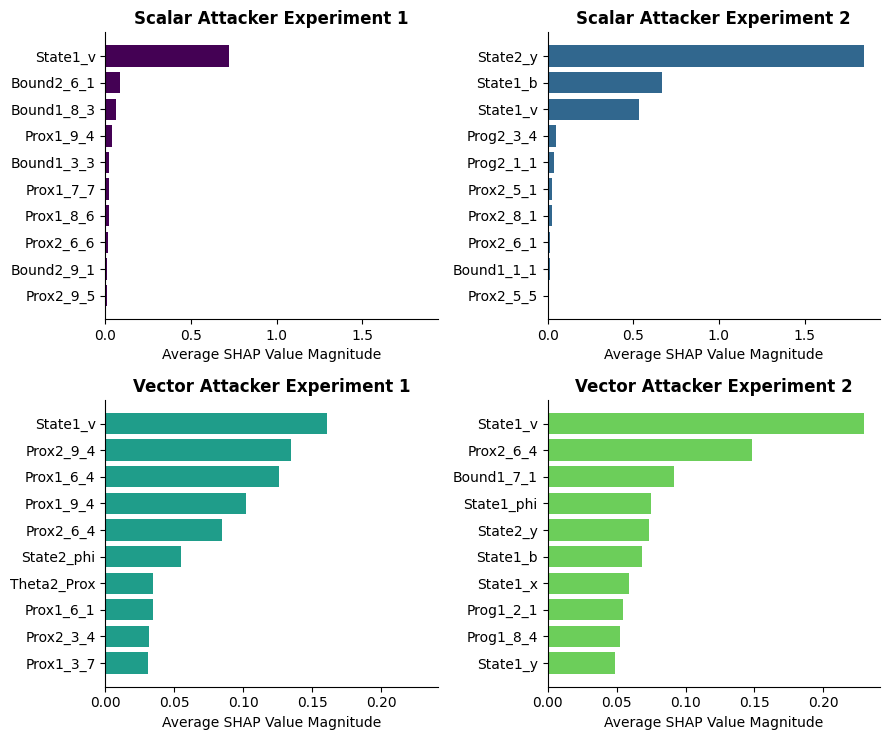

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

viridis_hex = [
    '#440154',  # Dark purple
    '#482777',  # Purple
    '#3f4a8a',  # Blue-purple
    '#31678e',  # Blue
    '#26838f',  # Teal-blue
    '#1f9d8a',  # Teal
    '#6cce5a',  # Green
    '#b6de2b',  # Yellow-green
    '#fee825',  # Yellow
    '#f0f921'   # Bright yellow
]

color_lst = [
    '#440154',  # Dark purple
    '#31678e',  # Blue
    '#1f9d8a',  # Teal
    '#6cce5a'   # Green
]

file_lst = ['../out/scalar_take1/action2/shap/baseline.feather',
            '../out/scalar_take2/action2/shap/baseline.feather',
            '../out/vector_take1/action2/shap/baseline.feather',
            '../out/vector_take2/action2/shap/baseline.feather']

# Create subplot titles
titles = ['Scalar Attacker Experiment 1', 'Scalar Attacker Experiment 2', 'Vector Attacker Experiment 1', 'Vector Attacker Experiment 2']

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(9, 7.5))
axes = axes.flatten()  # Flatten to make indexing easier

top_n = 10

# renaming to fit paper conventions
letter_map = {
    "A": "Prog",
    "B": "Bound",
    "C": "Prox",
    "a": "Prog",
    "b": "Bound",
    "c": "Prox"
}

def flip_state_or_code(name: str) -> str:
    # Rule 1: Handle State1/State2
    match_state = re.match(r"^State([12])(.*)", name)
    if match_state:
        num = match_state.group(1)
        rest = match_state.group(2)
        new_num = "2" if num == "1" else "1"
        return f"State{new_num}{rest}"

    match_state = re.match(r"^action([12])(.*)", name)
    if match_state:
        num = match_state.group(1)
        rest = match_state.group(2)
        new_num = "2" if num == "1" else "1"
        return f"action{new_num}{rest}"

    # Rule 2: Handle B1_xxx, C2_xxx, etc.
    match_code = re.match(r"^([A-Z])([12])(_\d+(?:_\d+)*$)", name)
    if match_code:
        letter, num, rest = match_code.groups()
        new_num = "2" if num == "1" else "1"
        new_letter = letter_map.get(letter, letter)
        
        # Split the rest into numbers (skip the underscores first)
        nums = rest.strip("_").split("_")
        
        # If original num == 1, swap the first two in nums
        if num == "1" and len(nums) >= 2:
            nums[0], nums[1] = nums[1], nums[0]
        
        # Rebuild
        return f"{new_letter}{new_num}_" + "_".join(nums)
    

    # --- Case 3: Handle Theta_x1 ---
    match_theta = re.match(r"^Theta_([abc])([12])$", name)
    if match_theta:
        letter, num = match_theta.groups()
        mapped = letter_map.get(letter, letter)
        flipped_num = "2" if num == "1" else "1"
        return f"Theta{flipped_num}_{mapped}"
    
    # Default: return unchanged
    return name


# First pass: find the max values for scalar and vector experiments separately
scalar_max = 0
vector_max = 0
for i, file in enumerate(file_lst):
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    if i < 2:  # Scalar experiments (indices 0, 1)
        scalar_max = max(scalar_max, top_features.max())
    else:  # Vector experiments (indices 2, 3)
        vector_max = max(vector_max, top_features.max())

# Second pass: plot with consistent scale within experiment types
for i, file in enumerate(file_lst):
    df = pd.read_feather(file)
    df.columns = [flip_state_or_code(c) for c in df.columns]

    # Remove the target column (assuming it's the last column based on your data)
    target_col = df.columns[-1]  # 'P2 Vector Cost'
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    # Plot on the corresponding subplot
    bars = axes[i].barh(range(len(top_features)), top_features.values,
                       color=color_lst[i])
    axes[i].set_yticks(range(len(top_features)))
    axes[i].set_yticklabels(top_features.index)
    axes[i].set_xlabel('Average SHAP Value Magnitude')
    axes[i].set_title(f'{titles[i]}', fontweight='bold',)
    
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    # Set consistent x-axis limits within experiment type
    if i < 2:  # Scalar experiments
        axes[i].set_xlim(0, scalar_max * 1.05)  # Add 5% padding
    else:  # Vector experiments
        axes[i].set_xlim(0, vector_max * 1.05)  # Add 5% padding

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

def shannon_entropy_shap(shap_values):
    """
    Calculate Shannon entropy from SHAP values using normalized absolute values.
    
    Parameters:
    shap_values: array-like, SHAP values for features
    
    Returns:
    float: Shannon entropy in nats
    """
    abs_shap = np.abs(shap_values)
    if abs_shap.sum() == 0:
        return 0
    probabilities = abs_shap / abs_shap.sum()
    return entropy(probabilities)  # base=e by default, units = nats

# Example usage
file_lst = ['../out/scalar_take1/action2/shap/baseline.feather',
            '../out/scalar_take2/action2/shap/baseline.feather',
            '../out/vector_take1/action2/shap/baseline.feather',
            '../out/vector_take2/action2/shap/baseline.feather']

titles = ['Scalar Attacker Experiment 1', 'Scalar Attacker Experiment 2', 
          'Vector Attacker Experiment 1', 'Vector Attacker Experiment 2']

for i, file in enumerate(file_lst):
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values
    mean_abs_shap = shap_values.abs().mean()
    
    # Calculate Shannon entropy
    shap_entropy = shannon_entropy_shap(mean_abs_shap.values)
    
    print(f"{titles[i]}: {shap_entropy:.3f} nats")

Scalar Attacker Experiment 1: 1.233 nats
Scalar Attacker Experiment 2: 1.409 nats
Vector Attacker Experiment 1: 4.516 nats
Vector Attacker Experiment 2: 3.924 nats


Shap values, 3 metrics and methods

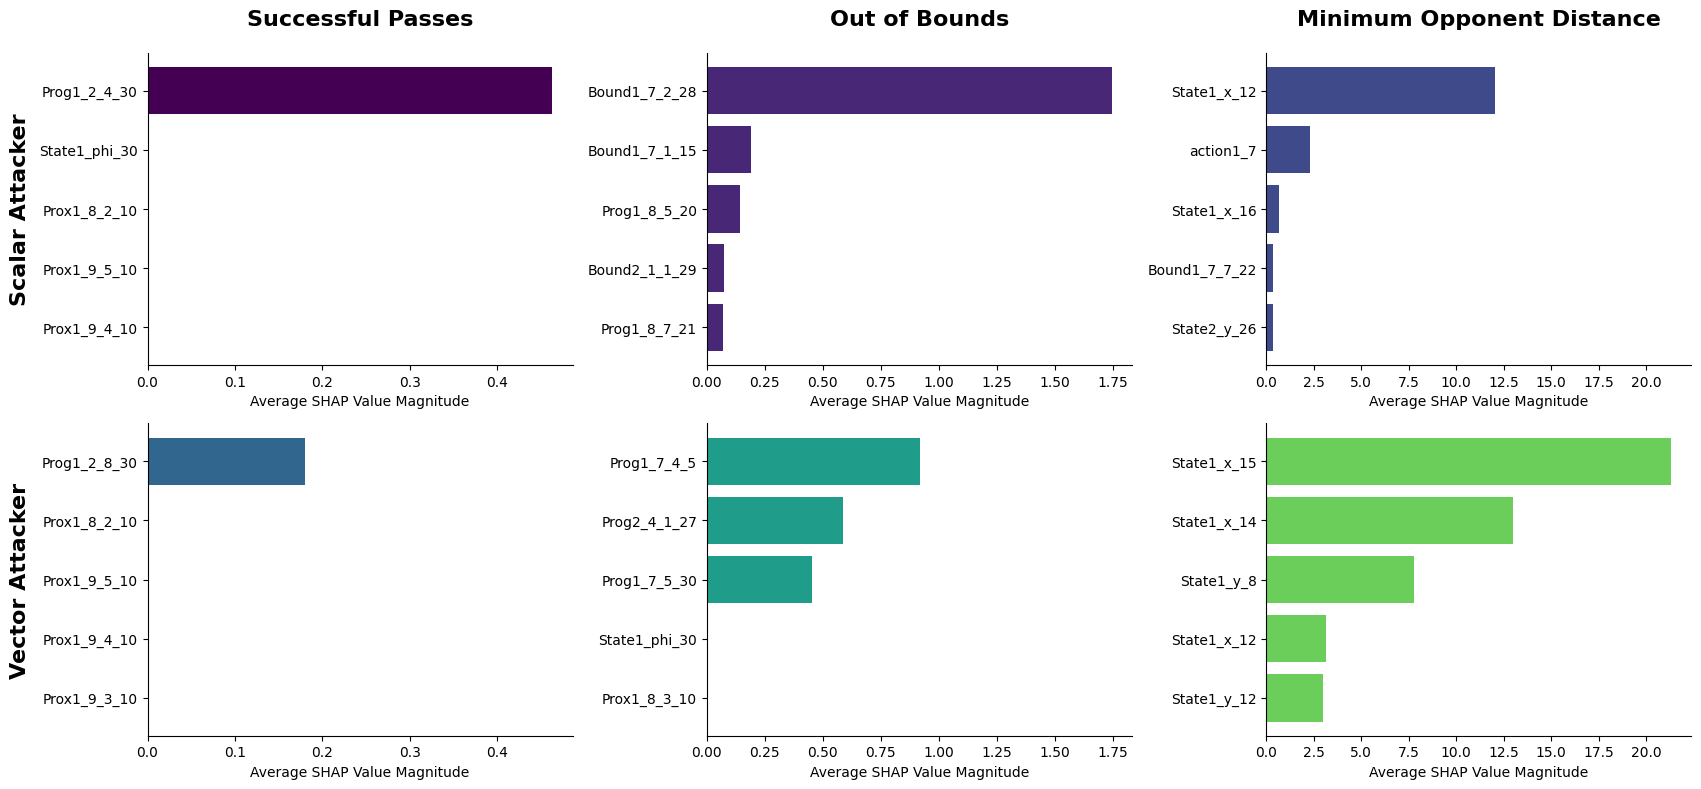

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

color_lst = [
    '#440154',  # Dark purple
    '#482777',  # Purple
    '#3f4a8a',  # Blue-purple
    '#31678e',  # Blue
    '#1f9d8a',  # Teal
    '#6cce5a',   # Green
]

file_lst = ['../out/scalar_take2/Passes P2/shap/baseline.feather',
            '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
            '../out/scalar_take2/Min_Distance/shap/baseline.feather',
            '../out/vector_take2/Passes P2/shap/baseline.feather',
            '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
            '../out/vector_take2/Min_Distance/shap/baseline.feather']

# Column titles (for each column)
column_titles = ['Successful Passes', 'Out of Bounds', 'Minimum Opponent Distance']
# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Create 2x3 subplot figure
fig, axes = plt.subplots(2, 3, figsize=(17, 8))

top_n = 5

# First pass: find the max values for each column separately
column_max = [0, 0, 0]  # For 3 columns
for i, file in enumerate(file_lst):
    col = i % 3   # Calculate column index
    
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    column_max[col] = max(column_max[col], top_features.max())

# Second pass: plot with consistent scale within each column
for i, file in enumerate(file_lst):
    row = i // 3  # Calculate row index
    col = i % 3   # Calculate column index
    
    df = pd.read_feather(file)
    df.columns = [flip_state_or_code(c) for c in df.columns]

    # Remove the target column (assuming it's the last column based on your data)
    target_col = df.columns[-1]  # 'P2 Vector Cost'
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    # Plot on the corresponding subplot
    bars = axes[row, col].barh(range(len(top_features)), top_features.values,
                               color=color_lst[i])
    axes[row, col].set_yticks(range(len(top_features)))
    axes[row, col].set_yticklabels(top_features.index)
    axes[row, col].set_xlabel('Average SHAP Value Magnitude')
    
    # Remove top and right spines
    axes[row, col].spines['top'].set_visible(False)
    axes[row, col].spines['right'].set_visible(False)
    
    # Set consistent x-axis limits within each column
    axes[row, col].set_xlim(0, column_max[col] * 1.05)  # Add 5% padding

# Add column titles
for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=16, fontweight='bold', pad=20)

# Add row titles
for row, title in enumerate(row_titles):
    axes[row, 0].text(-0.3, 0.5, title, transform=axes[row, 0].transAxes,
                      fontsize=16, fontweight='bold', rotation=90, 
                      verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

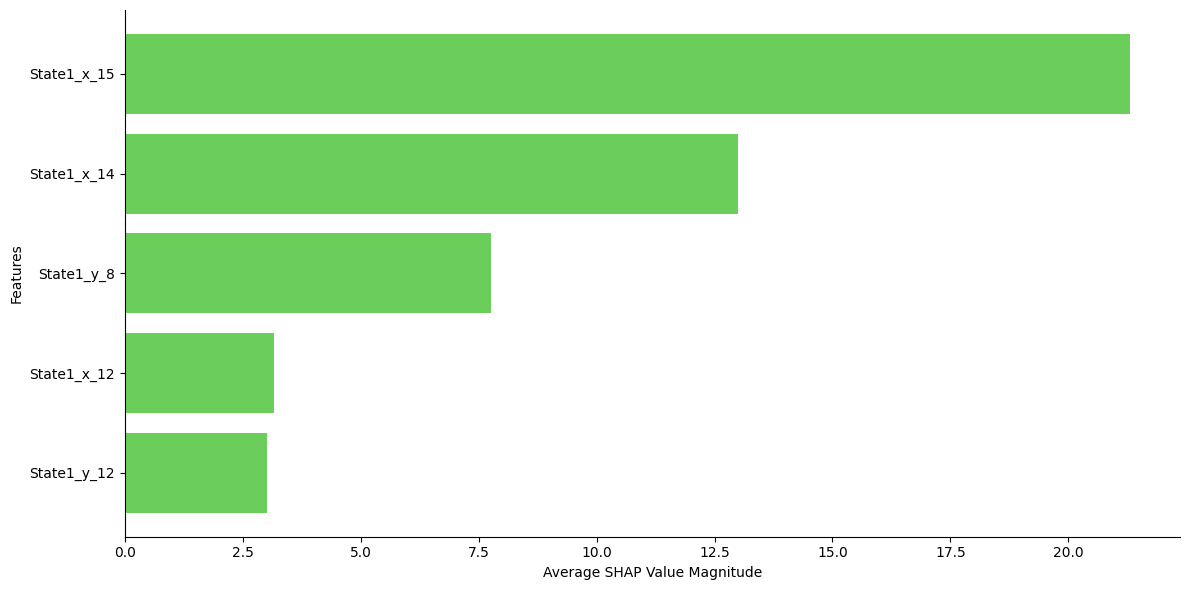

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

color_lst = [
    # '#440154',  # Dark purple
    # '#482777',  # Purple
    # '#3f4a8a',  # Blue-purple
    # '#31678e',  # Blue
    # '#1f9d8a',  # Teal
    '#6cce5a',   # Green
]

file_lst = ['../out/vector_take2/Min_Distance/shap/baseline.feather']

# Create single subplot figure
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

top_n = 5

# Process the single file
df = pd.read_feather(file_lst[0])
df.columns = [flip_state_or_code(c) for c in df.columns]  # Comment out if function not defined

# Remove the target column (assuming it's the last column)
target_col = df.columns[-1]
shap_values = df.drop(columns=[target_col])

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
top_features = mean_abs_shap.tail(top_n)

# Plot
bars = ax.barh(range(len(top_features)), top_features.values, color=color_lst[0])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index)
ax.set_xlabel('Average SHAP Value Magnitude')
ax.set_ylabel('Features')

# ax.set_title('Minimum Opponent Distance - SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
for i, file in enumerate(file_lst):
    row = i // 3  # Calculate row index
    col = i % 3   # Calculate column index
    
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values
    mean_abs_shap = shap_values.abs().mean()
    
    # Calculate Shannon entropy
    shap_entropy = shannon_entropy_shap(mean_abs_shap.values)
    
    # Create title using row and column titles
    title = f"{row_titles[row]} - {column_titles[col]}"
    print(f"{title}: {shap_entropy:.3f} nats")

Scalar Attacker - Successful Passes: 3.240 nats


Cost Matrix Heat Map

C:\Users\toazb\AppData\Local\Temp\ipykernel_7968\2622977663.py:172: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



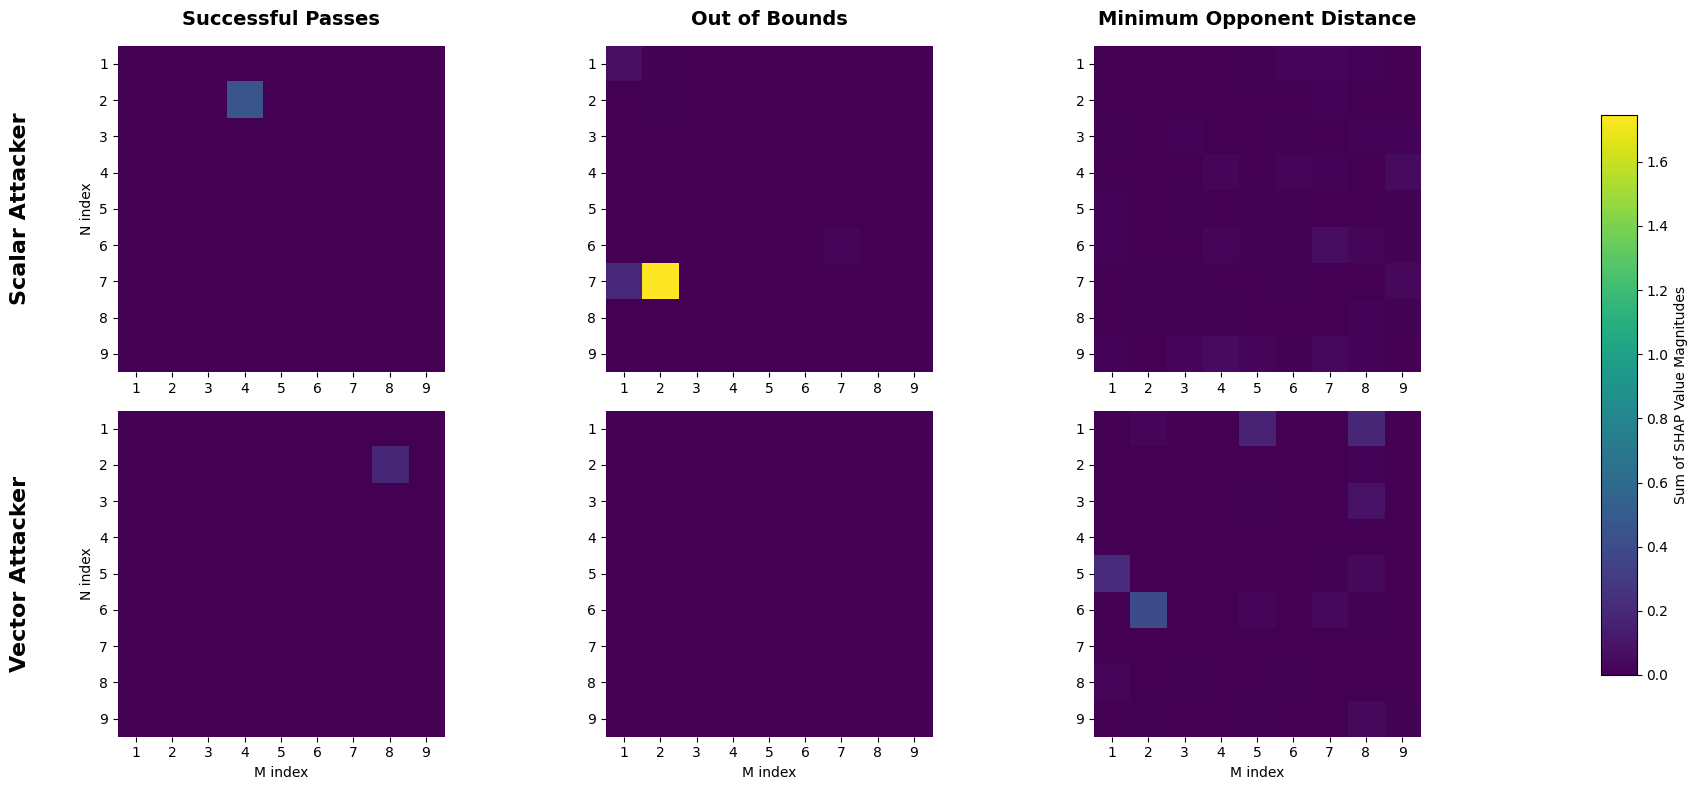

Summary of loaded data:
Scalar - Passes (A): 81 unique positions
Scalar - Out of Bounds (B): 81 unique positions
Scalar - Min_Distance (C): 81 unique positions
Vector - Passes (A): 81 unique positions
Vector - Out of Bounds (B): 81 unique positions
Vector - Min_Distance (C): 81 unique positions


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File paths and configuration
file_lst = [
    '../out/scalar_take2/Passes P2/shap/baseline.feather',
    '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Passes P2/shap/baseline.feather',
    '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Column titles (for each column) - 3 columns: A, B, C
column_titles = ['Successful Passes', 'Out of Bounds', 'Minimum Opponent Distance']

# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Mapping from problem type to group letter
problem_to_group = {
    'Passes': 'A',
    'Out of Bounds': 'B', 
    'Min_Distance': 'C'
}

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with NaN
    heatmap = np.full((9, 9), np.nan)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for (n, m), feature_list in feature_groups.items():
        # Sum the mean absolute SHAP values for all rounds at this position
        sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
        heatmap[n-1, m-1] = sum_shap  # Convert to 0-based indexing
    
    return heatmap, len(feature_groups)

def get_problem_type(filepath):
    """Extract problem type from filepath"""
    if 'Passes' in filepath:
        return 'Passes'
    elif 'Out of Bounds' in filepath:
        return 'Out of Bounds'
    elif 'Min_Distance' in filepath:
        return 'Min_Distance'
    return 'Unknown'

# Create 2x3 subplot figure
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Collect all heatmaps and their valid values for consistent color scaling
all_heatmaps = []
all_valid_values = []

# First pass: load all data and create heatmaps
for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Get problem type and corresponding group
        problem_type = get_problem_type(file_path)
        group_letter = problem_to_group.get(problem_type, 'A')
        
        # Extract features for this group
        group_features = []
        for col in shap_values.columns:
            match = re.match(rf'^{group_letter}\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, num_positions = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, num_positions, problem_type, group_letter))
        
        # Collect valid values for color scaling
        valid_values = heatmap[~np.isnan(heatmap)]
        if len(valid_values) > 0:
            all_valid_values.extend(valid_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.full((9, 9), np.nan), 0, 'Error', 'X'))

# Set consistent color scale
if all_valid_values:
    vmin, vmax = np.min(all_valid_values), np.max(all_valid_values)
else:
    vmin, vmax = 0, 1

# Second pass: plot all heatmaps
im = None
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row = i // 3  # 0 for scalar (first 3 files), 1 for vector (last 3 files)
    col = i % 3   # 0, 1, 2 for A, B, C respectively
    
    if num_positions == 0:
        axes[row, col].set_title(f"{problem_type} ({group_letter}) - No Data")
        axes[row, col].axis("off")
        continue
    
    # Create heatmap
    im = axes[row, col].imshow(heatmap, cmap="viridis", origin="upper", vmin=vmin, vmax=vmax)
    
    # Set ticks for 9x9 grid
    axes[row, col].set_xticks(np.arange(9))
    axes[row, col].set_yticks(np.arange(9))
    axes[row, col].set_xticklabels(np.arange(1, 10))
    axes[row, col].set_yticklabels(np.arange(1, 10))
    
    # Add subtle grid
    # axes[row, col].set_xticks(np.arange(-0.5, 9), minor=True)
    # axes[row, col].set_yticks(np.arange(-0.5, 9), minor=True)
    # axes[row, col].grid(which="minor", color="white", linestyle='-', linewidth=0.3, alpha=0.3)
    
    # Set title only for top row
    if row == 0:
        axes[row, col].set_title(column_titles[col], fontsize=14, fontweight='bold', pad=15)
    
    # Add axis labels
    if row == 1:  # Bottom row
        axes[row, col].set_xlabel("M index", fontsize=10)
    if col == 0:  # First column
        axes[row, col].set_ylabel("N index", fontsize=10)
    
    # Remove spines for cleaner look
    for spine in axes[row, col].spines.values():
        spine.set_visible(False)

# Add row titles
for row, title in enumerate(row_titles):
    axes[row, 0].text(-0.3, 0.5, title, transform=axes[row, 0].transAxes,
                     fontsize=16, fontweight='bold', rotation=90,
                     verticalalignment='center', horizontalalignment='center')

# Add colorbar
if im is not None:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, label="Sum of SHAP Value Magnitudes")
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row_type = "Scalar" if i < 3 else "Vector"
    print(f"{row_type} - {problem_type} ({group_letter}): {num_positions} unique positions")

In [10]:
import pandas as pd
import numpy as np
import re
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# File paths and configuration
file_lst = [
    '../out/scalar_take2/Passes P2/shap/baseline.feather',
    '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Passes P2/shap/baseline.feather',
    '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Column titles and row titles
column_titles = ['Passes (A)', 'Bounds (B)', 'Distance (C)']
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Mapping from problem type to group letter
problem_to_group = {
    'Passes': 'A',
    'Out of Bounds': 'B', 
    'Min_Distance': 'C'
}

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with zeros
    heatmap = np.zeros((9, 9))
    hover_text = np.empty((9, 9), dtype=object)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for i in range(9):
        for j in range(9):
            n, m = i + 1, j + 1  # Convert to 1-based indexing
            key = (n, m)
            
            if key in feature_groups:
                feature_list = feature_groups[key]
                sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
                heatmap[i, j] = sum_shap
                
                # Create hover text with feature details
                hover_info = f"Position ({n}, {m})<br>"
                hover_info += f"Total Importance: {sum_shap:.4f}<br>"
                hover_info += f"Features ({len(feature_list)}):<br>"
                
                # Sort by importance and show top features
                sorted_features = sorted([(f, mean_abs_shap[f]) for f in feature_list], 
                                       key=lambda x: x[1], reverse=True)
                
                for k, (feature, imp) in enumerate(sorted_features[:5]):  # Top 5
                    hover_info += f"  {feature}: {imp:.4f}<br>"
                
                if len(feature_list) > 5:
                    hover_info += f"  ... and {len(feature_list) - 5} more"
                
                hover_text[i, j] = hover_info
            else:
                hover_text[i, j] = f"Position ({n}, {m})<br>No data"
    
    return heatmap, hover_text

def get_problem_type(filepath):
    """Extract problem type from filepath"""
    if 'Passes' in filepath:
        return 'Passes'
    elif 'Out of Bounds' in filepath:
        return 'Out of Bounds'
    elif 'Min_Distance' in filepath:
        return 'Min_Distance'
    return 'Unknown'

# Load and process all data
all_heatmaps = []
all_hover_texts = []
all_valid_values = []

for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Get problem type and corresponding group
        problem_type = get_problem_type(file_path)
        group_letter = problem_to_group.get(problem_type, 'A')
        
        # Extract features for this group
        group_features = []
        for col in shap_values.columns:
            match = re.match(rf'^{group_letter}\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, hover_text = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, problem_type, group_letter))
        all_hover_texts.append(hover_text)
        
        # Collect valid values for color scaling
        nonzero_values = heatmap[heatmap > 0]
        if len(nonzero_values) > 0:
            all_valid_values.extend(nonzero_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.zeros((9, 9)), 'Error', 'X'))
        all_hover_texts.append(np.full((9, 9), f"Error loading {file_path}", dtype=object))

# Set consistent color scale
if all_valid_values:
    vmax = np.max(all_valid_values)
else:
    vmax = 1

# Create subplot figure
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f"{title}" for title in column_titles],
    vertical_spacing=0.15,
    horizontal_spacing=0.1
)

# Add heatmaps to subplots
for i, ((heatmap, problem_type, group_letter), hover_text) in enumerate(zip(all_heatmaps, all_hover_texts)):
    row = i // 3 + 1  # Plotly uses 1-based indexing
    col = i % 3 + 1
    
    fig.add_trace(
        go.Heatmap(
            z=heatmap,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_text,
            colorscale='Viridis',
            zmin=0,
            zmax=vmax,
            showscale=(i == 0),  # Only show colorbar for first subplot
            colorbar=dict(
                title="Total |SHAP| Value",
                # titleside="right",
                x=1.02,
                len=0.8
            ) if i == 0 else None
        ),
        row=row, col=col
    )
    
    # Update axes for this subplot
    fig.update_xaxes(
        title_text="M index" if row == 2 else None,
        tickmode='linear',
        tick0=0,
        dtick=1,
        tickvals=list(range(9)),
        ticktext=[str(i+1) for i in range(9)],
        row=row, col=col
    )
    
    fig.update_yaxes(
        title_text="N index" if col == 1 else None,
        tickmode='linear',
        tick0=0,
        dtick=1,
        tickvals=list(range(9)),
        ticktext=[str(i+1) for i in range(9)],
        row=row, col=col
    )

# Add row annotations
for i, row_title in enumerate(row_titles):
    fig.add_annotation(
        x=-0.15, y=0.75 - i * 0.5,
        text=row_title,
        textangle=90,
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=16, color="black"),
        xanchor="center", yanchor="middle"
    )

# Update layout
fig.update_layout(
    title={
        'text': "Interactive SHAP Heatmaps - Hover for Details",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    height=800,
    width=1200,
    margin=dict(l=100, r=100, t=100, b=50)
)

fig.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, problem_type, group_letter) in enumerate(all_heatmaps):
    row_type = "Scalar" if i < 3 else "Vector"
    num_positions = np.sum(heatmap > 0)
    print(f"{row_type} - {problem_type} ({group_letter}): {num_positions} positions with data")

print("\nInteractive features:")
print("- Hover over any cell to see detailed feature information")
print("- Zoom and pan using plotly controls")
print("- Click and drag to select regions")

Summary of loaded data:
Scalar - Passes (A): 1 positions with data
Scalar - Out of Bounds (B): 6 positions with data
Scalar - Min_Distance (C): 81 positions with data
Vector - Passes (A): 1 positions with data
Vector - Out of Bounds (B): 0 positions with data
Vector - Min_Distance (C): 51 positions with data

Interactive features:
- Hover over any cell to see detailed feature information
- Zoom and pan using plotly controls
- Click and drag to select regions


C:\Users\toazb\AppData\Local\Temp\ipykernel_7968\1735262335.py:188: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



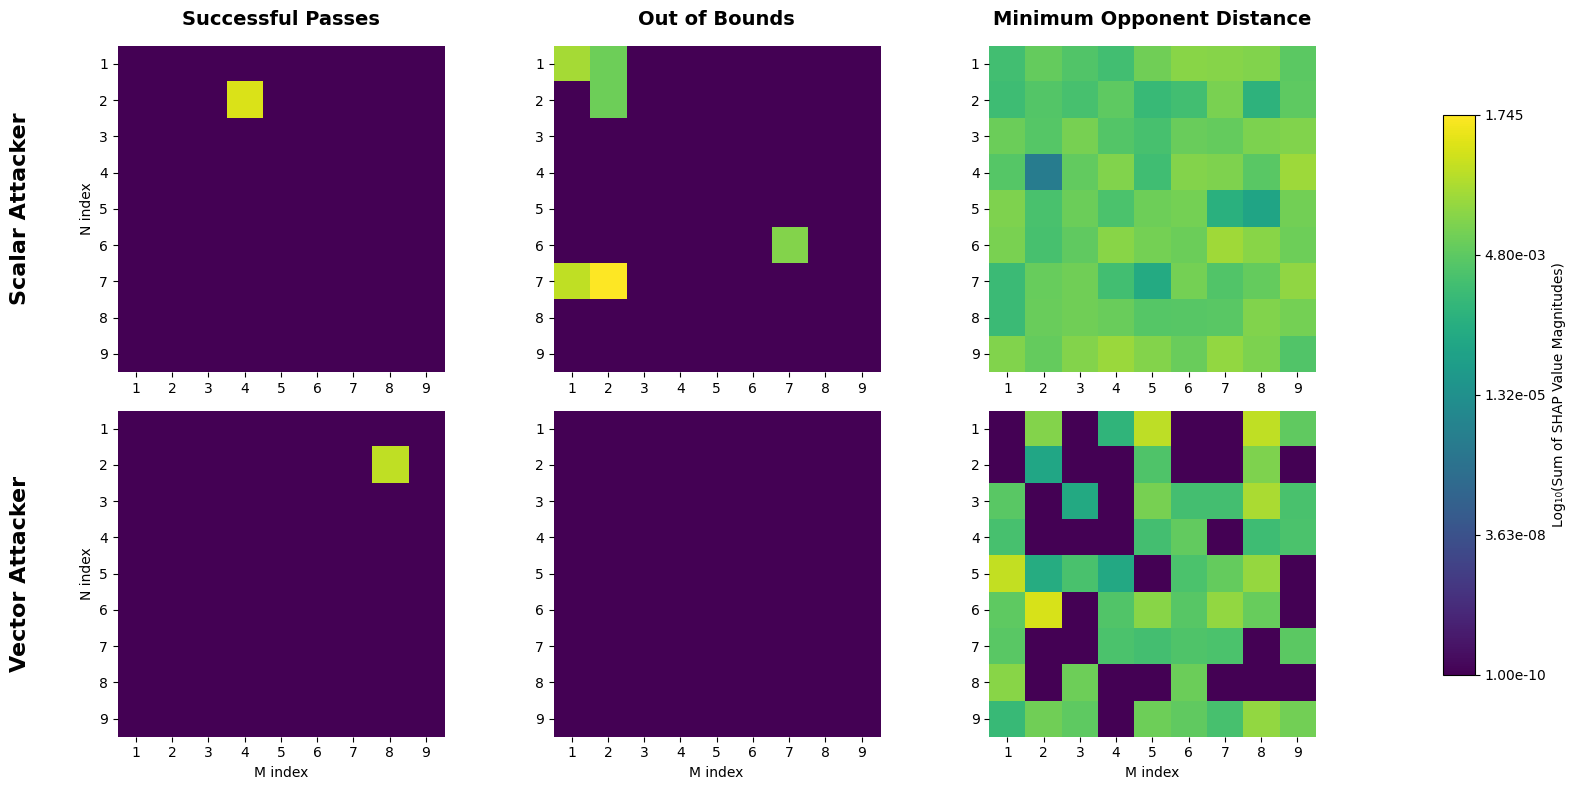

Summary of loaded data:
Scalar - Passes (A): 81 unique positions
Scalar - Out of Bounds (B): 81 unique positions
Scalar - Min_Distance (C): 81 unique positions
Vector - Passes (A): 81 unique positions
Vector - Out of Bounds (B): 81 unique positions
Vector - Min_Distance (C): 81 unique positions


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File paths and configuration
file_lst = [
    '../out/scalar_take2/Passes P2/shap/baseline.feather',
    '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Passes P2/shap/baseline.feather',
    '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Column titles (for each column) - 3 columns: A, B, C
column_titles = ['Successful Passes', 'Out of Bounds', 'Minimum Opponent Distance']

# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Mapping from problem type to group letter
problem_to_group = {
    'Passes': 'A',
    'Out of Bounds': 'B', 
    'Min_Distance': 'C'
}

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with NaN
    heatmap = np.full((9, 9), np.nan)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for (n, m), feature_list in feature_groups.items():
        # Sum the mean absolute SHAP values for all rounds at this position
        sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
        heatmap[n-1, m-1] = sum_shap  # Convert to 0-based indexing
    
    return heatmap, len(feature_groups)

def get_problem_type(filepath):
    """Extract problem type from filepath"""
    if 'Passes' in filepath:
        return 'Passes'
    elif 'Out of Bounds' in filepath:
        return 'Out of Bounds'
    elif 'Min_Distance' in filepath:
        return 'Min_Distance'
    return 'Unknown'

# Create 2x3 subplot figure
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Collect all heatmaps and their valid values for consistent color scaling
all_heatmaps = []
all_valid_values = []

# First pass: load all data and create heatmaps
for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Get problem type and corresponding group
        problem_type = get_problem_type(file_path)
        group_letter = problem_to_group.get(problem_type, 'A')
        
        # Extract features for this group
        group_features = []
        for col in shap_values.columns:
            match = re.match(rf'^{group_letter}\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, num_positions = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, num_positions, problem_type, group_letter))
        
        # Collect valid values for color scaling
        valid_values = heatmap[~np.isnan(heatmap)]
        if len(valid_values) > 0:
            all_valid_values.extend(valid_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.full((9, 9), np.nan), 0, 'Error', 'X'))

# Set consistent color scale with log scaling
if all_valid_values:
    # Use log scale, but handle zeros by adding small epsilon
    epsilon = 1e-10
    all_valid_values = np.array(all_valid_values)
    log_values = np.log10(all_valid_values + epsilon)
    vmin, vmax = np.min(log_values), np.max(log_values)
else:
    vmin, vmax = -10, 0  # Default log scale range

# Second pass: plot all heatmaps
im = None
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row = i // 3  # 0 for scalar (first 3 files), 1 for vector (last 3 files)
    col = i % 3   # 0, 1, 2 for A, B, C respectively
    
    if num_positions == 0:
        axes[row, col].set_title(f"{problem_type} ({group_letter}) - No Data")
        axes[row, col].axis("off")
        continue
    
    # Apply log transformation to heatmap data
    log_heatmap = np.full_like(heatmap, np.nan)
    mask = ~np.isnan(heatmap)
    if np.any(mask):
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        log_heatmap[mask] = np.log10(heatmap[mask] + epsilon)
    
    # Create heatmap with log-scaled data
    im = axes[row, col].imshow(log_heatmap, cmap="viridis", origin="upper", vmin=vmin, vmax=vmax)
    
    # Set ticks for 9x9 grid
    axes[row, col].set_xticks(np.arange(9))
    axes[row, col].set_yticks(np.arange(9))
    axes[row, col].set_xticklabels(np.arange(1, 10))
    axes[row, col].set_yticklabels(np.arange(1, 10))
    
    # Set title only for top row
    if row == 0:
        axes[row, col].set_title(column_titles[col], fontsize=14, fontweight='bold', pad=15)
    
    # Add axis labels
    if row == 1:  # Bottom row
        axes[row, col].set_xlabel("M index", fontsize=10)
    if col == 0:  # First column
        axes[row, col].set_ylabel("N index", fontsize=10)
    
    # Remove spines for cleaner look
    for spine in axes[row, col].spines.values():
        spine.set_visible(False)

# Add row titles
for row, title in enumerate(row_titles):
    axes[row, 0].text(-0.3, 0.5, title, transform=axes[row, 0].transAxes,
                     fontsize=16, fontweight='bold', rotation=90,
                     verticalalignment='center', horizontalalignment='center')

# Add colorbar
if im is not None:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, label="Log₁₀(Sum of SHAP Value Magnitudes)")
    cbar.ax.tick_params(labelsize=10)
    
    # Add custom tick labels to show actual values
    if len(all_valid_values) > 0:
        # Create meaningful tick positions
        tick_positions = np.linspace(vmin, vmax, 5)
        actual_values = 10**tick_positions
        tick_labels = [f"{val:.2e}" if val < 0.01 else f"{val:.3f}" for val in actual_values]
        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels(tick_labels)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row_type = "Scalar" if i < 3 else "Vector"
    print(f"{row_type} - {problem_type} ({group_letter}): {num_positions} unique positions")

C:\Users\toazb\AppData\Local\Temp\ipykernel_7968\1764382969.py:150: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



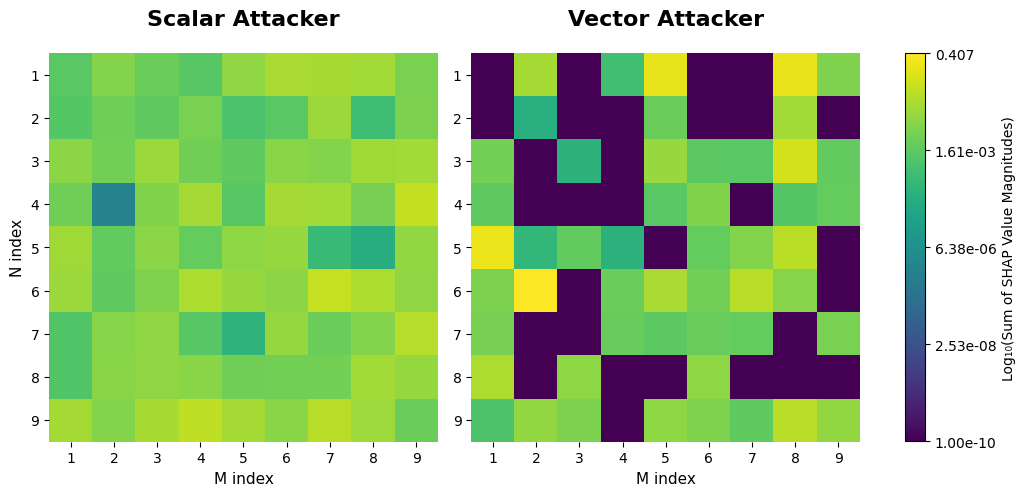

Summary of loaded data:
Scalar Attacker - Minimum Opponent Distance: 81 unique positions
Vector Attacker - Minimum Opponent Distance: 81 unique positions


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File paths for Min_Distance only
file_lst = [
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with NaN
    heatmap = np.full((9, 9), np.nan)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for (n, m), feature_list in feature_groups.items():
        # Sum the mean absolute SHAP values for all rounds at this position
        sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
        heatmap[n-1, m-1] = sum_shap  # Convert to 0-based indexing
    
    return heatmap, len(feature_groups)

# Create 2x1 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Collect all heatmaps and their valid values for consistent color scaling
all_heatmaps = []
all_valid_values = []

# First pass: load all data and create heatmaps
for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Extract C (Min_Distance) features only
        group_features = []
        for col in shap_values.columns:
            match = re.match(r'^C\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, num_positions = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, num_positions))
        
        # Collect valid values for color scaling
        valid_values = heatmap[~np.isnan(heatmap)]
        if len(valid_values) > 0:
            all_valid_values.extend(valid_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.full((9, 9), np.nan), 0))

# Set consistent color scale with log scaling
if all_valid_values:
    # Use log scale, but handle zeros by adding small epsilon
    epsilon = 1e-10
    all_valid_values = np.array(all_valid_values)
    log_values = np.log10(all_valid_values + epsilon)
    vmin, vmax = np.min(log_values), np.max(log_values)
else:
    vmin, vmax = -10, 0  # Default log scale range

# Second pass: plot all heatmaps
im = None
for i, (heatmap, num_positions) in enumerate(all_heatmaps):
    if num_positions == 0:
        axes[i].set_title(f"{row_titles[i]} - No Data")
        axes[i].axis("off")
        continue
    
    # Apply log transformation to heatmap data
    log_heatmap = np.full_like(heatmap, np.nan)
    mask = ~np.isnan(heatmap)
    if np.any(mask):
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        log_heatmap[mask] = np.log10(heatmap[mask] + epsilon)
    
    # Create heatmap with log-scaled data
    im = axes[i].imshow(log_heatmap, cmap="viridis", origin="upper", vmin=vmin, vmax=vmax)
    
    # Set ticks for 9x9 grid
    axes[i].set_xticks(np.arange(9))
    axes[i].set_yticks(np.arange(9))
    axes[i].set_xticklabels(np.arange(1, 10))
    axes[i].set_yticklabels(np.arange(1, 10))
    
    # Set title
    axes[i].set_title(f"{row_titles[i]}", 
                     fontsize=16, fontweight='bold', pad=20)
    
    # Add axis labels
    axes[i].set_xlabel("M index", fontsize=11)
    if i == 0:  # Only add Y-label to the first (left) subplot
        axes[i].set_ylabel("N index", fontsize=11)
    
    # Remove spines for cleaner look
    for spine in axes[i].spines.values():
        spine.set_visible(False)

# Add colorbar
if im is not None:
    cbar_ax = fig.add_axes([0.91, 0.2575, 0.02, 0.485])
    cbar = fig.colorbar(im, cax=cbar_ax, label="Log₁₀(Sum of SHAP Value Magnitudes)")
    cbar.ax.tick_params(labelsize=10)
    
    # Add custom tick labels to show actual values
    if len(all_valid_values) > 0:
        # Create meaningful tick positions
        tick_positions = np.linspace(vmin, vmax, 5)
        actual_values = 10**tick_positions
        tick_labels = [f"{val:.2e}" if val < 0.01 else f"{val:.3f}" for val in actual_values]
        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels(tick_labels)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, num_positions) in enumerate(all_heatmaps):
    print(f"{row_titles[i]} - Minimum Opponent Distance: {num_positions} unique positions")

## Sembas


Critical moments superimposed

3
(235, 3) (235, 3)


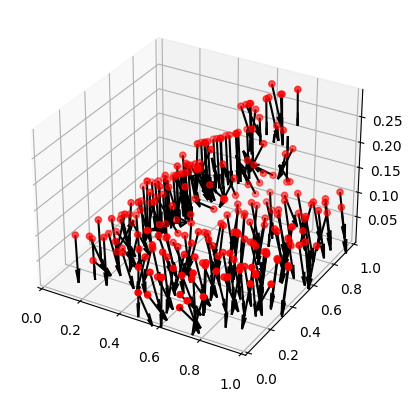

In [ ]:
import numpy as np
import json

from numpy import ndarray
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

def subplot_3d():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    return fig, ax

def draw_arrows(ax: Axes, locs: ndarray, dirs: ndarray, scale: float = 0.1):
    handles = []
    for bp, s in zip(locs, dirs):
        if is_3d:
            handles.append(ax.quiver(*bp, *(s * scale), color='black'))
        else:
            print(bp)
            print(s)
            handles.append(ax.arrow(*bp, *(s * scale), head_width=scale * 0.1, head_length=scale*0.2))

def subplot():
    if is_3d:
        fig, ax = subplot_3d()
    else:
        fig, ax = plt.subplots()

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return fig, ax
    
def load_boundary(path) -> ndarray:
    with open(path) as f: # TODO
        data = json.load(f)
    return np.array(data['boundary']["boundary_points"]), np.array(data['boundary']["boundary_surface"])
    
# Load boundary
path = "../data/boundaries/old_bounds/scalar_collision/close_tail.json"
bpoints, bdir = load_boundary(path)

ndim = bdir.shape[1]
is_3d = ndim == 3

assert ndim <= 3, "Cannot visualize more than 3 dimensions"

print(len(bpoints.T))
print(bpoints.shape, bdir.shape)

# show surface direction
fig, ax = subplot()

ax.scatter(*bpoints.T, color="red")
draw_arrows(ax, bpoints, bdir)
plt.show()


In [14]:
import numpy as np
import json
from numpy import ndarray
import plotly.graph_objects as go

viridis_hex = [
    '#440154',  # Dark purple
    '#482777',  # Purple
    '#3f4a8a',  # Blue-purple
    '#31678e',  # Blue
    '#26838f',  # Teal-blue
    '#1f9d8a',  # Teal
    '#6cce5a',  # Green
    '#b6de2b',  # Yellow-green
    '#fee825',  # Yellow
    '#f0f921'   # Bright yellow
]

def load_boundary(path) -> ndarray:
    with open(path) as f:
        data = json.load(f)
    return np.array(data['boundary']["boundary_points"]), np.array(data['boundary']["boundary_surface"])

def create_arrow_3d(start, direction, scale=0.2):
    """Create 3D arrow using line and cone"""
    end = start + direction * scale
    
    # Arrow shaft
    shaft = go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color='#1f9d8a', width=6),
        showlegend=False
    )
    
    # Arrow head (cone)
    head = go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[direction[0]], v=[direction[1]], w=[direction[2]],
        sizemode="absolute",
        sizeref=scale*0.3,
        colorscale=[[0, '#1f9d8a'], [1, '#1f9d8a']],
        showscale=False,
        showlegend=False
    )
    
    return [shaft, head]

# Load boundary data
path = "../data/boundaries/old_bounds/scalar_pass/far_tail.json"
bpoints, bdir = load_boundary(path)
ndim = bdir.shape[1]
is_3d = ndim == 3

# Calculate center of mass and average direction
center_of_mass = np.mean(bpoints, axis=0)
average_direction = np.mean(bdir, axis=0)
average_direction = average_direction / np.linalg.norm(average_direction)

print(f"Center of mass: {center_of_mass}")
print(f"Average direction: {average_direction}")

# Create figure
fig = go.Figure()

# Add boundary points
fig.add_trace(
    go.Scatter3d(
        x=bpoints[:, 0], y=bpoints[:, 1], z=bpoints[:, 2],
        mode='markers',
        marker=dict(size=4, color='#440154', opacity=0.7),
        showlegend=False
    )
)

# Add center of mass
fig.add_trace(
    go.Scatter3d(
        x=[center_of_mass[0]], y=[center_of_mass[1]], z=[center_of_mass[2]],
        mode='markers',
        marker=dict(size=8, color='#1f9d8a'),
        showlegend=False
    )
)

# Add average arrow
arrow_traces = create_arrow_3d(center_of_mass, average_direction, scale=0.2)
for trace in arrow_traces:
    fig.add_trace(trace)

# Update 3D scene
fig.update_scenes(
    xaxis_title="Progress Weight",
    yaxis_title="Bounds Weight", 
    zaxis_title="Proximity Weight",
    aspectmode='cube'
)

# Update layout
fig.update_layout(
    width=800,
    height=800,
    showlegend=False,
    scene_camera=dict(
    eye=dict(x=0.5, y=2.2, z=0.5),    # Camera positioned below and slightly to the right
    up=dict(x=0, y=0, z=1),            # Z-axis pointing up
    center=dict(x=0, y=0, z=0)         # Looking at the origin/center of data
)
)

# Show the plot
fig.show()

Center of mass: [0.50114805 0.49033524 0.47197585]
Average direction: [-0.708304    0.69303738  0.13418136]


In [15]:
df = pd.read_feather('../data/scalar/combined_stats_sca_cleaned.feather')
df = df[['Win P2', 'Out of Bounds P2', 'Collisions', 'Theta_a2', 'Theta_b2', 'Theta_c2', 'Scenario']]

In [16]:
target_col = ['Win P2', 'Out of Bounds P2', 'Collisions']
df[target_col] = df[target_col].apply(lambda x: (x != 0).astype(int))
df

Win P2  Out of Bounds P2  Collisions  Theta_a2  Theta_b2  Theta_c2  \
0         1                 1           0     0.001       0.0      0.00   
1         1                 1           0     0.001       0.0      0.25   
2         1                 1           0     0.001       0.0      0.50   
3         1                 1           0     0.001       0.0      0.75   
4         1                 1           0     0.001       0.0      1.00   
..      ...               ...         ...       ...       ...       ...   
495       1                 0           0     1.000       1.0      0.00   
496       0                 0           0     1.000       1.0      0.25   
497       0                 0           0     1.000       1.0      0.50   
498       0                 0           0     1.000       1.0      0.75   
499       0                 0           0     1.000       1.0      1.00   

     Scenario  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
495         2  
496         2  
497         2  
498         2  
499         2  

[500 rows x 7 columns]

In [17]:
import numpy as np
import json
from numpy import ndarray
import plotly.graph_objects as go
from plotly.subplots import make_subplots

viridis_hex = [
    '#440154',  # Dark purple
    '#482777',  # Purple
    '#3f4a8a',  # Blue-purple
    '#31678e',  # Blue
    '#26838f',  # Teal-blue
    '#1f9d8a',  # Teal
    '#6cce5a',  # Green
    '#b6de2b',  # Yellow-green
    '#fee825',  # Yellow
    '#f0f921'   # Bright yellow
]

def load_boundary(path) -> ndarray:
    with open(path) as f:
        data = json.load(f)
    return np.array(data['boundary']["boundary_points"]), np.array(data['boundary']["boundary_surface"])

def create_arrow_3d(start, direction, scale=0.2):
    """Create 3D arrow using line and cone"""
    end = start + direction * scale
    
    # Arrow shaft
    shaft = go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color='#1f9d8a', width=6),
        showlegend=False
    )
    
    # Arrow head (cone)
    head = go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[direction[0]], v=[direction[1]], w=[direction[2]],
        sizemode="absolute",
        sizeref=scale*0.3,
        colorscale=[[0, '#1f9d8a'], [1, '#1f9d8a']],
        showscale=False,
        showlegend=False
    )
    
    return [shaft, head]

# Create subplots with 3D scenes
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Boundary Analysis', 'Win/Loss Distribution'],
    specs=[[{'type': 'scene'}, {'type': 'scene'}]]
)

# Left plot: Boundary visualization
path = "../data/boundaries/old_bounds/scalar_pass/far_tail.json"
bpoints, bdir = load_boundary(path)

# Calculate center of mass and average direction
center_of_mass = np.mean(bpoints, axis=0)
average_direction = np.mean(bdir, axis=0)
average_direction = average_direction / np.linalg.norm(average_direction)

# Add boundary points
fig.add_trace(
    go.Scatter3d(
        x=bpoints[:, 0], y=bpoints[:, 1], z=bpoints[:, 2],
        mode='markers',
        marker=dict(size=4, color='#440154', opacity=0.7),
        showlegend=False,
        name='Boundary Points'
    ),
    row=1, col=1
)

# Add center of mass
fig.add_trace(
    go.Scatter3d(
        x=[center_of_mass[0]], y=[center_of_mass[1]], z=[center_of_mass[2]],
        mode='markers',
        marker=dict(size=8, color='#1f9d8a'),
        showlegend=False,
        name='Center of Mass'
    ),
    row=1, col=1
)

# Add arrow traces
arrow_traces = create_arrow_3d(center_of_mass, average_direction, scale=0.2)
for trace in arrow_traces:
    fig.add_trace(trace, row=1, col=1)

# Right plot: Win/Loss scatter
df_scenario = df[df['Scenario'] == 1]

X = df_scenario['Theta_a2'].to_numpy()
Y = df_scenario['Theta_b2'].to_numpy()
Z = df_scenario['Theta_c2'].to_numpy()
target = df_scenario['Win P2'].to_numpy()

fig.add_trace(
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(
            size=4, 
            color=target, 
            opacity=0.7,
            colorscale=[[0, 'red'], [1, 'blue']],
            showscale=True,
            colorbar=dict(
                title="Win P2",
                tickvals=[0, 1],
                ticktext=['Loss', 'Win'],
                x=1.02  # Position colorbar to the right
            )
        ),    
        showlegend=False,
        name='Win/Loss Data'
    ),
    row=1, col=2
)

# Update 3D scenes
fig.update_scenes(
    xaxis_title="Progress Weight",
    yaxis_title="Bounds Weight", 
    zaxis_title="Proximity Weight",
    aspectmode='cube',
    camera=dict(
        eye=dict(x=0.5, y=2.2, z=0.5),
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0)
    )
)

# Update layout
fig.update_layout(
    width=1600,
    height=800,
    showlegend=False,
    title="3D Analysis: Boundary vs Win/Loss Distribution"
)

# Show the plot
fig.show()

print(f"Center of mass: {center_of_mass}")
print(f"Average direction: {average_direction}")

Center of mass: [0.50114805 0.49033524 0.47197585]
Average direction: [-0.708304    0.69303738  0.13418136]


In [18]:
import numpy as np
import json
from numpy import ndarray
import plotly.graph_objects as go

def load_boundary(path) -> ndarray:
    with open(path) as f:
        data = json.load(f)
    return np.array(data['boundary']["boundary_points"]), np.array(data['boundary']["boundary_surface"])

# Create single figure
fig = go.Figure()

# Load boundary data
path = "../data/boundaries/old_bounds/scalar_pass/far_tail.json"
bpoints, bdir = load_boundary(path)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['2D Boundary and Grid Search', '3D Boundary'],
    specs=[[{'type': 'xy'}, {'type': 'scene'}]]
)
fig.update_annotations(font_size=24)

# Add boundary points (x=progress, y=bounds)
fig.add_trace(
    go.Scatter(
        x=bpoints[:, 0], y=bpoints[:, 1],  # Progress vs Bounds
        mode='markers',
        marker=dict(
            size=10, 
            color='#482777', 
            opacity=1.0,
            line=dict(width=0.5, color='black')
        ),
        name='Boundary Point'
    ),
    row=1, col=1
)

# Add Win/Loss scatter data (x=progress, y=bounds)
df_scenario = df[df['Scenario'] == 1]

X = df_scenario['Theta_a2'].to_numpy()  # Progress weight
Y = df_scenario['Theta_b2'].to_numpy()  # Bounds weight
target = df_scenario['Win P2'].to_numpy()

# Separate win and loss points
win_mask = target == 1
loss_mask = target == 0

# Add Win points
fig.add_trace(
    go.Scatter(
        x=X[win_mask], y=Y[win_mask],
        mode='markers',
        marker=dict(
            size=10, 
            color='blue', 
            opacity=1.0,
            line=dict(width=0.5, color='black')
        ),
        text=[f'Point {i+1}<br>Win<br>'
              f'({X[i]:.2f}, {Y[i]:.2f})'
              for i in np.where(win_mask)[0]],
        hoverinfo='text',   
        name='Success'
    ),
    row=1, col=1
)

# Add Loss points
fig.add_trace(
    go.Scatter(
        x=X[loss_mask], y=Y[loss_mask],
        mode='markers',
        marker=dict(
            size=10, 
            color='red', 
            opacity=1.0,
            line=dict(width=0.5, color='black')
        ),
        text=[f'Point {i+1}<br>Loss<br>'
              f'({X[i]:.2f}, {Y[i]:.2f})'
              for i in np.where(loss_mask)[0]],
        hoverinfo='text',   
        name='Failure'
    ),
    row=1, col=1

)

# Calculate center of mass and average direction
center_of_mass = np.mean(bpoints, axis=0)
average_direction = np.mean(bdir, axis=0)
average_direction = average_direction / np.linalg.norm(average_direction)

# Add boundary points
# Calculate center of mass and average direction
center_of_mass = np.mean(bpoints, axis=0)
average_direction = np.mean(bdir, axis=0)
average_direction = average_direction / np.linalg.norm(average_direction)

# Add boundary points
fig.add_trace(
    go.Scatter3d(
        x=bpoints[:, 0], y=bpoints[:, 1], z=bpoints[:, 2],
        mode='markers',
        marker=dict(size=4, color='#440154', opacity=0.7),
        showlegend=False,
        name='Boundary Points'
    ),
    row=1, col=2
)

# Add center of mass
fig.add_trace(
    go.Scatter3d(
        x=[center_of_mass[0]], y=[center_of_mass[1]], z=[center_of_mass[2]],
        mode='markers',
        marker=dict(size=8, color='#1f9d8a'),
        showlegend=False,
        name='Center of Mass'
    ),
    row=1, col=2
)

# Add arrow traces
arrow_traces = create_arrow_3d(center_of_mass, average_direction, scale=0.2)
for trace in arrow_traces:
    fig.add_trace(trace, row=1, col=2)

# Update 2D subplot axes
fig.update_xaxes(title_text="Progress Weight",
                 showline=True,
                 linewidth=2,
                 linecolor='black',
                 mirror=False,
                 row=1, col=1)
fig.update_yaxes(title_text="Bounds Weight",
                 showline=True,
                 linewidth=2,
                 linecolor='black',
                 mirror=False,
                 row=1, col=1)

# Update 3D scenes
fig.update_scenes(
    xaxis_title="Progress Weight",
    yaxis_title="Bounds Weight", 
    zaxis_title="Proximity Weight",
    aspectmode='cube',
    camera=dict(
        eye=dict(x=1.5, y=1.5, z=0.8),
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0)
    )
)

# Update layout
fig.update_layout(
    width=1400,
    height=700,
    margin=dict(l=60, r=60, t=80, b=60),
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1
    ),
    plot_bgcolor='white',
    paper_bgcolor='white'
)


# Show the plot
fig.show()

In [19]:
import numpy as np
import json
from numpy import ndarray
import plotly.graph_objects as go

PURPLE = '#9C27B0'
# Colorblind-friendly colors
SUCCESS_COLOR = '#0173B2'  # Blue - for wins/success
FAILURE_COLOR = '#DE8F05'  # Orange - for losses/failure  
BOUNDARY_COLOR = '#029E73' # Teal/Green - for boundary points
ARROW_COLOR = '#000000'    # Black - for arrows and center of mass

SUCCESS_COLOR = '#648fff'  # Blue
FAILURE_COLOR = '#dc267f'  # Orange
BOUNDARY_COLOR = '#fe6100' # Pink/Magenta (colorblind-safe purple alternative)

SUCCESS_COLOR = 'blue'  # Blue
FAILURE_COLOR = 'red'  # Orange
BOUNDARY_COLOR = PURPLE # Pink/Magenta (colorblind-safe purple alternative)

def load_boundary(path) -> ndarray:
    with open(path) as f:
        data = json.load(f)
    return np.array(data['boundary']["boundary_points"]), np.array(data['boundary']["boundary_surface"])

def create_arrow_3d(start, direction, scene, scale=0.2):
    """Create 3D arrow using line and cone"""
    
    end = start + direction * scale
    
    color = 'black'

    # Arrow shaft
    shaft = go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=6),
        showlegend=False
    )
    
    # Arrow head (cone)
    head = go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[direction[0]], v=[direction[1]], w=[direction[2]],
        sizemode="absolute",
        sizeref=scale*0.5,
        colorscale=[[0, color], [1, color]],
        showscale=False,
        showlegend=False,
        scene=scene
    )
    
    return [shaft, head]

# Create single figure
fig = go.Figure()

X = df_scenario['Theta_a2'].to_numpy()
Y = df_scenario['Theta_b2'].to_numpy()
Z = df_scenario['Theta_c2'].to_numpy()
target = df_scenario['Win P2'].to_numpy()

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'xy'}, {'type': 'scene'}], [{'type': 'xy'}, {'type': 'scene'}]],
    vertical_spacing=0.08
)
fig.update_annotations(font_size=24)


grid_path_lst = ['../data/scalar/combined_stats_sca_cleaned.feather', '../data/vector/combined_stats_vec_cleaned.feather']
boundary_path_lst = ["../data/boundaries/old_bounds/scalar_pass/far_tail.json", "../data/boundaries/old_bounds/vector_pass/far_tail.json"]

scenario = 1

for i, grid_path, in enumerate(grid_path_lst):
    boundary_path = boundary_path_lst[i]

    df = pd.read_feather(grid_path)
    df = df[['Win P2', 'Out of Bounds P2', 'Collisions', 'Theta_a2', 'Theta_b2', 'Theta_c2', 'Scenario']]
    target_col = ['Win P2', 'Out of Bounds P2', 'Collisions']
    df[target_col] = df[target_col].apply(lambda x: (x != 0).astype(int))

    df_scenario = df[df['Scenario'] == scenario]

    # Add W in/Loss scatter data (x=progress, y=bounds)
    df_scenario = df[df['Scenario'] == 1]

    X = df_scenario['Theta_a2'].to_numpy()  # Progress weight
    Y = df_scenario['Theta_b2'].to_numpy()  # Bounds weight
    target = df_scenario['Win P2'].to_numpy()

    # Separate win and loss points
    win_mask = target == 1
    loss_mask = target == 0

    is_show_legend = bool(i)

    # Add Win points
    fig.add_trace(
        go.Scatter(
            x=X[win_mask], y=Y[win_mask],
            mode='markers',
            marker=dict(
                size=10, 
                color=SUCCESS_COLOR,
                opacity=1.0,
                line=dict(width=0.5, color='black'),
                symbol='square'
            ),
            text=[f'Point {i+1}<br>Win<br>'
                f'({X[i]:.2f}, {Y[i]:.2f})'
                for i in np.where(win_mask)[0]],
            hoverinfo='text',   
            name='Success',
            showlegend=is_show_legend
        ),
        row=i+1, col=1
    )

    # Load boundary data
    bpoints, bdir = load_boundary(boundary_path)

    # Add boundary points (x=progress, y=bounds)
    fig.add_trace(
        go.Scatter(
            x=bpoints[:, 0], y=bpoints[:, 1],  # Progress vs Bounds
            mode='markers',
            marker=dict(
                size=10, 
                color= BOUNDARY_COLOR, 
                opacity=1.0,
                line=dict(width=0.5, color='black')
            ),
            name='Boundary',
            showlegend=is_show_legend
        ),
        row=i+1, col=1
    )

    # Add Loss points
    fig.add_trace(
        go.Scatter(
            x=X[loss_mask], y=Y[loss_mask],
            mode='markers',
            marker=dict(
                size=10, 
                color=FAILURE_COLOR, 
                opacity=1.0,
                line=dict(width=0.5, color='black'),
                symbol='triangle-up'
            ),
            text=[f'Point {i+1}<br>Loss<br>'
                f'({X[i]:.2f}, {Y[i]:.2f})'
                for i in np.where(loss_mask)[0]],
            hoverinfo='text',   
            name='Failure',
            showlegend=is_show_legend
        ),
        row=i+1, col=1

    )

    # Calculate center of mass and average direction
    center_of_mass = np.mean(bpoints, axis=0)
    average_direction = np.mean(bdir, axis=0)
    average_direction = average_direction / np.linalg.norm(average_direction)

    # Add boundary points
    # Calculate center of mass and average direction
    center_of_mass = np.mean(bpoints, axis=0)
    average_direction = np.mean(bdir, axis=0)
    average_direction = average_direction / np.linalg.norm(average_direction)

    # Add boundary points
    fig.add_trace(
        go.Scatter3d(
            x=bpoints[:, 0], y=bpoints[:, 1], z=bpoints[:, 2],
            mode='markers',
            marker=dict(
                size=4, 
                color= BOUNDARY_COLOR, 
                opacity=1.0,
                line=dict(width=0.5, color='black')
            ),            showlegend=False,
            name='Boundary Points'
        ),
        row=i+1, col=2
    )

    # Add center of mass
    fig.add_trace(
        go.Scatter3d(
            x=[center_of_mass[0]], y=[center_of_mass[1]], z=[center_of_mass[2]],
            mode='markers',
            marker=dict(size=8, color='black'),
            showlegend=False,
            name='Center of Mass'
        ),
        row=i+1, col=2
    )

    # Add arrow traces
    arrow_scale = 0.2 if i == 0 else 0.2  # Smaller arrow for second plot
    scene_name = "scene1" if i == 0 else "scene2"

    arrow_traces = create_arrow_3d(center_of_mass, average_direction, scene_name, scale=arrow_scale)
    for trace in arrow_traces:
        fig.add_trace(trace, row=i+1, col=2)

    # Update 2D subplot axes
    fig.update_xaxes(title_text="Progress Weight",
                    showline=True,
                    linewidth=2,
                    linecolor='black',
                    mirror=False,
                    row=i+1, col=1)
    fig.update_yaxes(title_text="Bounds Weight",
                    showline=True,
                    linewidth=2,
                    linecolor='black',
                    mirror=False,
                    row=i+1, col=1)

    if i == 0:
        camera_dict = dict(
            eye=dict(x=-1.6, y=-1.6, z=0.8),
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0)
        )
        # Update 3D scenes
        fig.update_scenes(
            aspectmode='cube',
            xaxis=dict(
            title="Progress Weight",
            range=[0, 1],  # Set fixed range
            # autorange=False,  # Disable auto-ranging
        ),
        yaxis=dict(
            title="Bounds Weight", 
            range=[0, 0.99],
            # autorange=False,
        ),
        zaxis=dict(
            title="Proximity Weight",
            range=[0, 1],
            # autorange=False,
        ),
            camera=camera_dict,
            row=i+1, col=2
        )

    else:
        # Update 3D scenes

        camera_dict = dict(
            eye=dict(x=-1.6, y=-1.6, z=0.8),
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0)
        )
        # eye=dict(x=-1.2, y=-2.2, z=0.5),
        fig.update_scenes(
            aspectmode='cube',
            xaxis=dict(
            title="Progress Weight",
            range=[-0.15, 1],  # Set fixed range
            # autorange=False,  # Disable auto-ranging
        ),
        yaxis=dict(
            title="Bounds Weight", 
            range=[0, 1.05],
            # autorange=False,
        ),
        zaxis=dict(
            title="Proximity Weight",
            range=[-0.05, 1],
            # autorange=False,
        ),
            camera=camera_dict,
            row=i+1, col=2
        )

# Column titles (apply to top row only)
column_titles = ["2D Boundary and Grid Search", "3D Boundary"]
for col, title in enumerate(column_titles, start=1):
    fig.add_annotation(
        text=title,
        xref="paper", yref="paper",
        x=0.25 if col == 1 else 0.75,  # center over each column
        y=1.05,  # above top row
        showarrow=False,
        font=dict(size=20, color="black", family="Arial", weight="bold"),
        xanchor="center"
    )

# Row titles
row_titles = ["Scalar Attacker", "Vector Attacker"]
for row, title in enumerate(row_titles, start=1):
    y_pos = 0.75 if row == 1 else 0.25  # vertical midpoint of each row
    fig.add_annotation(
        text=title,
        xref="paper", yref="paper",
        x=-0.12, y=y_pos,   # left of the plots
        showarrow=False,
        textangle=-90,      # rotate vertically
        font=dict(size=20, color="black", family="Arial", weight="bold"),
        xanchor="center", yanchor="middle"
    )


# Update layout
fig.update_layout(
    width=1200,
    height=1000,
    margin=dict(l=150, r=40, t=60, b=60),
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1
    ),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Show the plot
# fig.show(renderer="browser")
fig.show(renderer="notebook")

# fig.write_image("test.png", height=1200, width=1000)